In [92]:
import warnings
import numpy as np
import pandas as pd
import re, gensim

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models, similarities
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from operator import itemgetter
from wordcloud import WordCloud
import string
import math


warnings.filterwarnings('ignore')

### Lectura de datos de los conjuntos de datos descargados y realizamos un solo dataframe para trabajar de forma mas eficiente

In [61]:
df_paper = pd.read_csv("archive/papers.csv")
df_author = pd.read_csv("archive/authors.csv")
data = pd.concat([df_author, df_paper], join='outer', axis=1)
data = data.loc[:,~data.columns.duplicated()]
data.head()

,source_id,first_name,last_name,institution,year,title,abstract,full_text
0,27,Alan,Murray,NaN,1987.0,Bit-Serial Neural Networks,NaN,573 \n\nBIT - SERIAL NEURAL NETWORKS \n\nAlan...
1,27,Anthony,Smith,NaN,1987.0,Connectivity Versus Entropy,NaN,1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser S...
2,27,Zoe,Butler,NaN,1987.0,The Hopfield Model with Multi-Level Neurons,NaN,278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...
3,63,Yaser,Abu-Mostafa,NaN,1987.0,How Neural Nets Work,NaN,442 \n\nAlan Lapedes \nRobert Farber \n\nThe...
4,60,Michael,Fleisher,NaN,1987.0,Spatial Organization of Neural Networks: A Pro...,NaN,740 \n\nSPATIAL ORGANIZATION OF NEURAL NEn...


#### Eliminamos datos vacios y transformamos texto a minusculas

In [62]:
data = data.dropna()
data['abstract'] = data['abstract'].str.lower()
data.head()

,source_id,first_name,last_name,institution,year,title,abstract,full_text
5449,2443,Nikos,Vlassis,Adobe Research,2014.0,Generalized Dantzig Selector: Application to t...,we propose a generalized dantzig selector (gds...,Generalized Dantzig Selector:\n\nApplication t...
6380,2650,Nikos,Vlassis,Adobe Research,2016.0,Optimal Cluster Recovery in the Labeled Stocha...,we consider the problem of community detection...,Optimal Cluster Recovery\n\nin the Labeled Sto...
6972,2783,David,Fleet,University of Toronto,2017.0,Scalable Demand-Aware Recommendation,recommendation for e-commerce with a mix of du...,Scalable Demand-Aware Recommendation\n\nJinfen...
7193,3025,Nikos,Vlassis,Adobe Research,2017.0,A framework for Multi-A(rmed)/B(andit) Testing...,we propose an alternative framework to existin...,A framework for Multi-A(rmed)/B(andit) Testing...
9239,508,William,Uther,NICTA & UNSW,2019.0,Optimistic Regret Minimization for Extensive-F...,we study the performance of optimistic regret-...,Optimistic Regret Minimization for Extensive-F...


#### Obtencion de datos con stopwords

In [63]:
# Descarga de conjunto
nltk.download('stopwords')

#Seleccion de lenguaje
stop = stopwords.words('english')
stop[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/famvazpom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

### Limpieza de stopwords y otros signos de puntuación

In [64]:
data_cleaned = data.copy()
data_cleaned['abstract'] = data_cleaned['abstract'].str.replace("[^\w\s]",'').str.lower()
data_cleaned['abstract'] = data_cleaned['abstract'].str.replace("[^\D]",'').str.lower()
data_cleaned['abstract'] = data_cleaned['abstract'].str.replace(" {2,}",' ').str.lower()
data_cleaned['abstract'] = data_cleaned['abstract'].apply(lambda x: [item for item in x.split() if item not in stop])
data_cleaned['abstract']

5449    [propose, generalized, dantzig, selector, gds,...
6380    [consider, problem, community, detection, clus...
6972    [recommendation, ecommerce, mix, durable, nond...
7193    [propose, alternative, framework, existing, se...
9239    [study, performance, optimistic, regretminimiz...
Name: abstract, dtype: object

### Obtencion de los valores unicos de los valores obtenidos

In [65]:
unicas = corpora.Dictionary(data_cleaned.abstract)
print(unicas)

Dictionary(390 unique tokens: ['admm', 'analysis', 'aspects', 'ball', 'based']...)


#### Aplicamos LDA

In [66]:
cuerpos = [unicas.doc2bow(doc) for doc in data_cleaned.abstract]
lda = models.LdaMulticore( corpus= cuerpos,num_topics=10,id2word= unicas,random_state = 1,passes= 2,workers = 2)

#### Obtenemos los temas obtenidos del modelado anterior

In [67]:
lda.print_topics()

[(0,
  '0.010*"items" + 0.009*"clusters" + 0.006*"clustering" + 0.006*"mab" + 0.005*"algorithms" + 0.005*"algorithm" + 0.005*"parameters" + 0.005*"true" + 0.005*"set" + 0.004*"time"'),
 (1,
  '0.031*"clusters" + 0.026*"items" + 0.017*"parameters" + 0.015*"clustering" + 0.013*"set" + 0.012*"algorithm" + 0.012*"labeled" + 0.012*"model" + 0.011*"true" + 0.011*"lsbm"'),
 (2,
  '0.038*"norm" + 0.036*"gds" + 0.023*"estimation" + 0.023*"statistical" + 0.022*"analysis" + 0.022*"ksupport" + 0.016*"gaussian" + 0.015*"error" + 0.015*"proximal" + 0.015*"widths"'),
 (3,
  '0.005*"rate" + 0.005*"algorithms" + 0.005*"optimistic" + 0.004*"game" + 0.004*"cfr" + 0.004*"regret" + 0.004*"show" + 0.004*"games" + 0.004*"dilated" + 0.004*"converge"'),
 (4,
  '0.021*"items" + 0.020*"problem" + 0.020*"product" + 0.019*"time" + 0.019*"category" + 0.019*"utility" + 0.019*"purchase" + 0.018*"recommendation" + 0.013*"millions" + 0.013*"interpurchase"'),
 (5,
  '0.028*"mab" + 0.023*"time" + 0.018*"fdr" + 0.018*"tes

### Temas
Para la visualización, se desplegarán los temas mas recurrentes en los archivos en una nube de palabras.\
Con esto, necesitamos sacar todas las palabras de los datos obtenidos anteriormente.

A grandes rasgos, utilizamos una exprecion regular para eliminar números, signos de puntacion y similares


In [151]:
import re
patron = r'[0-9\*\"\.\+]' 
temas=[]
for topic in lda.print_topics():
    tema = re.sub(patron, '', topic[1])
    temas.append([tema])
temas

[['items  clusters  clustering  mab  algorithms  algorithm  parameters  true  set  time'],
 ['clusters  items  parameters  clustering  set  algorithm  labeled  model  true  lsbm'],
 ['norm  gds  estimation  statistical  analysis  ksupport  gaussian  error  proximal  widths'],
 ['rate  algorithms  optimistic  game  cfr  regret  show  games  dilated  converge'],
 ['items  problem  product  time  category  utility  purchase  recommendation  millions  interpurchase'],
 ['mab  time  fdr  tests  test  algorithms  companies  control  data  run'],
 ['game  rate  algorithms  dilated  optimistic  regret  cfr  show  converge  games'],
 ['mab  time  algorithms  test  fdr  tests  online  results  new  framework'],
 ['clusters  items  clustering  parameters  problem  algorithm  random  misclassified  lsbm  true'],
 ['time  recommendation  problem  purchase  category  data  utility  items  estimation  product']]

### Nubes de palaras
Ahora desplegamos las palabras en una nube

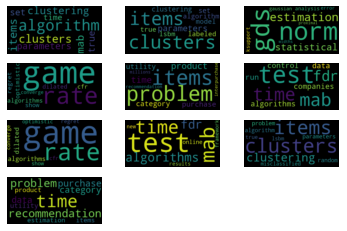

In [152]:
fig,ax = plt.subplots(math.ceil(len(topics)/3),3)
i = 0
for a in ax:
    
    for b in a:
        b.axis('off')
        if i < len(topics):
            wordcloud = WordCloud().generate(temas[i][0])
            b.imshow(wordcloud, interpolation='bilinear')
            b.axis("off")
        
        i+=1
    

## Conclusión
Como podemos ver, sin necesidad de leer los documentos podemos saber que algunos de los temas abordados en los mismos son cosas como algoritmos, clusters, juegos, problemas, etc. 

Esto nos puede ayudar para poder filtrar documentos y poder clasificar estos mismos para realizar una busqueda de documentos que nos pueda servir en alguna investigación

##### 160300153 - Vazquez Pompa Noe